In [51]:
# import os
# import shutil
# from sklearn.model_selection import train_test_split

# # Define paths
# data_dir = './Trash_Dataset/'
# train_dir = './Trash_Dataset_Split/train'
# val_dir = './Trash_Dataset_Split/test'
# classes = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

# # Create directories for train and validation sets
# for split_dir in [train_dir, val_dir]:
#     os.makedirs(split_dir, exist_ok=True)
#     for class_name in classes:
#         os.makedirs(os.path.join(split_dir, class_name), exist_ok=True)



In [52]:
# # Split the data
# for class_name in classes:
#     class_dir = os.path.join(data_dir, class_name)
#     images = os.listdir(class_dir)
#     train_images, val_images = train_test_split(images, test_size=0.2, random_state=42)
    
#     # Move files to training directory
#     for img in train_images:
#         shutil.move(os.path.join(class_dir, img), os.path.join(train_dir, class_name, img))
    
#     # Move files to validation directory
#     for img in val_images:
#         shutil.move(os.path.join(class_dir, img), os.path.join(val_dir, class_name, img))

# print("Data split and moved successfully.")


Data split and moved successfully.


In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import skimage.io
import tensorflow 
import tqdm
import glob

from tqdm import tqdm 

from skimage.io import imread, imshow
from skimage.transform import resize

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Flatten, BatchNormalization, Dropout, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array

%matplotlib inline

In [2]:
# DATA AUGMENTATION

In [3]:
train_datagen = ImageDataGenerator(rescale = 1.0 / 255.0,
                                   zoom_range = 0.4,
                                   rotation_range = 10,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1.0 / 255.0,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1.0 / 255.0)

In [6]:
# dataset  = train_datagen.flow_from_directory(directory = './Trash_Dataset',
#                                                    target_size = (224,224),
#                                                    class_mode = 'binary',
#                                                    batch_size = 128, 
#                                                    subset = 'training')

In [7]:
# path = './Trash_Dataset'

# import os
# files = os.listdir(path)
# print(files)

In [8]:
train_dataset  = train_datagen.flow_from_directory(directory = './Trash_Dataset_Split/train',
                                                   target_size = (224,224),
                                                   class_mode = 'binary',
                                                   batch_size = 128, 
                                                   subset = 'training')


Found 1617 images belonging to 6 classes.


In [9]:
valid_dataset = valid_datagen.flow_from_directory(directory = './Trash_Dataset_Split/train',
                                                  target_size = (224,224),
                                                  class_mode = 'binary',
                                                  batch_size = 128, 
                                                  subset = 'validation')

Found 402 images belonging to 6 classes.


In [10]:
# Class Indices 

train_dataset.class_indices

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}

 20%|█████████                                    | 1/5 [00:01<00:05,  1.38s/it]

1.0


 40%|██████████████████                           | 2/5 [00:02<00:04,  1.37s/it]

0.0


 60%|███████████████████████████                  | 3/5 [00:04<00:02,  1.36s/it]

3.0


 80%|████████████████████████████████████         | 4/5 [00:05<00:01,  1.36s/it]

1.0


100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.35s/it]

0.0


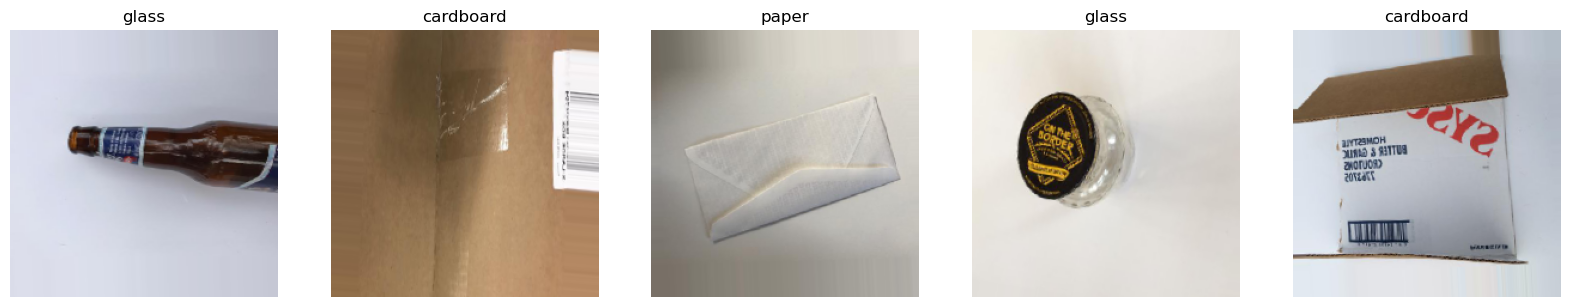

In [11]:
# Viewing Images

fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize = (20,20))

for i in tqdm(range(5)):
    rand1 = np.random.randint(len(train_dataset))
    rand2 = np.random.randint(128)
    ax[i].imshow(train_dataset[rand1][0][rand2])
    ax[i].axis('off')
    label = train_dataset[rand1][1][rand2]
    print(label)
    if label == 0:
        ax[i].set_title('cardboard')
    elif label == 1:
        ax[i].set_title('glass')
    elif label == 2:
        ax[i].set_title('metal')
    elif label == 3:
        ax[i].set_title('paper')
    elif label == 4:
        ax[i].set_title('plastic')
    else:
        ax[i].set_title('trash')
#     {'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5
    

In [12]:
# Defining Model

base_model = VGG16(input_shape=(224,224,3), 
                   include_top=False,
                   weights="imagenet")

In [13]:
# Freezing Layers 

for layer in base_model.layers:
    layer.trainable=False

In [14]:
# Summary

base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [15]:
# Defining Layers

model=Sequential()
model.add(base_model)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))

In [16]:
# Summary

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [17]:
# Model Compile 

OPT    = tensorflow.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss='binary_crossentropy',
              metrics=[tensorflow.keras.metrics.AUC(name = 'auc')],
              optimizer=OPT)

In [18]:
# Defining Callbacks

filepath = './best_weights.keras'

earlystopping = EarlyStopping(monitor = 'val_auc', 
                              mode = 'max' , 
                              patience = 5,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_auc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [ ]:
# Model Fitting 

model_history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 10,
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/10


/Users/aniketshetty/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - auc: 0.7344 - loss: -2.0868 
Epoch 1: val_auc improved from -inf to 0.88593, saving model to ./best_weights.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 230s 18s/step - auc: 0.7374 - loss: -2.3302 - val_auc: 0.8859 - val_loss: -15.5031
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - auc: 0.8004 - loss: -17.4216 
Epoch 2: val_auc improved from 0.88593 to 0.89116, saving model to ./best_weights.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 236s 18s/step - auc: 0.8011 - loss: -17.6656 - val_auc: 0.8912 - val_loss: -45.6618
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - auc: 0.8316 - loss: -32.1054 
Epoch 3: val_auc improved from 0.89116 to 0.92620, saving model to ./best_weights.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 259s 20s/step - auc: 0.8331 - loss: -32.3555 - val_auc: 0.9262 - val_loss: -79.5585
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - auc: 0.8700 - loss: -44.9000 
Epoch 4: val_auc did not improve from 0.92620
13/13 ━━━━━━━━━━━━━━━━━━━━ 273s 21s/step - au

In [ ]:
# MODEL EVALUATION


In [ ]:
# Summarize the model loss

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [ ]:
# Summarize models auc

plt.plot(model_history.history['auc'])
plt.plot(model_history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [ ]:
# Test Data 

test_data = test_datagen.flow_from_directory(directory = '../input/waste-classification-data/DATASET/TEST',
                                             target_size = (224,224),
                                             class_mode = 'binary',
                                             batch_size = 128)

In [ ]:
# Evaluating Loss and AUC - Test Data 

model.evaluate(test_data)